In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from circuit_toolkit.layer_hook_utils import featureFetcher, featureFetcher_module
from circuit_toolkit.GAN_utils import upconvGAN
from circuit_toolkit.CNN_scorers import TorchScorer, load_featnet

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [4]:
model, _ = load_featnet("resnet50_linf8") # robust model 

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


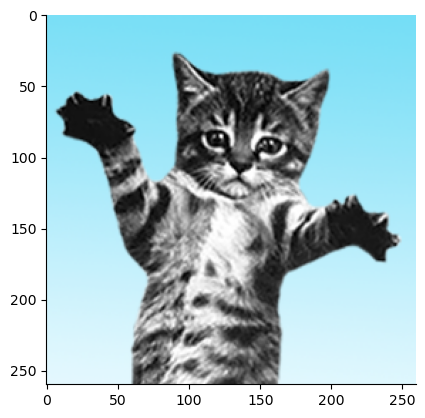

In [6]:
# image of a cat 
# https://static.boredpanda.com/blog/wp-content/uploads/2018/04/5acb63d83493f__700-png.jpg
# load this and show it with matplotlib
# load it with PIL, and wget urllib
import torch
from PIL import Image
import urllib.request

img = Image.open(urllib.request.urlopen("http://cat-bounce.com/cb.png"))
plt.imshow(img)
plt.show()

In [34]:
fetcher = featureFetcher_module()
fetcher.record_module(model.layer3, "layer3")
model = model.cuda().eval()

In [36]:
# turn it into a tensor, pass it to the model 
imgtsr = torch.from_numpy(np.array(img)).permute(2, 0, 1).unsqueeze(0).float()
with torch.no_grad():
    scores = model(imgtsr.cuda())

In [37]:
print(fetcher["layer3"].shape)
target_activation = fetcher["layer3"][0].detach()

torch.Size([1, 1024, 17, 17])


In [ ]:

def score_function(x):
    model(x.cuda())
    loss = torch.nn.functional.mse_loss(fetcher["layer3"], target_activation)
    return loss


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_3252604/4107431205.py:23: UserWarning: Using a target size (torch.Size([1024, 17, 17])) that is different to the input size (torch.Size([1, 1024, 17, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(record_activations, target_activation)
100%|██████████| 1000/1000 [00:09<00:00, 104.44it/s, loss=2.97e-5]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


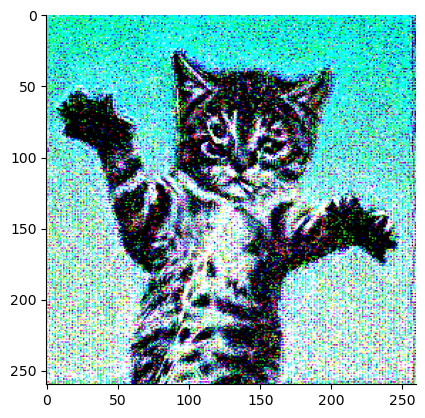

In [8]:
from tqdm import trange, tqdm
from torchvision.transforms import Normalize, Compose, ToTensor

normalizer = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalizer = Normalize([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], [1 / 0.229, 1 / 0.224, 1 / 0.225])

fetcher = featureFetcher_module()
fetcher.record_module(model.layer3, "layer3", ingraph=True)
imgtsr = ToTensor()(img)
# preprocess the image
imgtsr_pp = normalizer(imgtsr)[None, :, :, :]
with torch.no_grad():
    model(imgtsr_pp.cuda())
target_activation = fetcher["layer3"][0].detach()

x = torch.randn_like(imgtsr_pp, requires_grad=True)
optim = torch.optim.Adam([x], lr=0.1)
pbar = trange(1000)
for i in pbar:
    optim.zero_grad()
    model(x.cuda())
    record_activations = fetcher["layer3"]
    loss = torch.nn.functional.mse_loss(record_activations, target_activation)
    loss.backward()
    optim.step()
    pbar.set_postfix(loss=loss.item())
plt.imshow(x[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_3252604/4171549969.py:23: UserWarning: Using a target size (torch.Size([2048, 9, 9])) that is different to the input size (torch.Size([1, 2048, 9, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(record_activations, target_activation)
100%|██████████| 1000/1000 [00:10<00:00, 99.50it/s, loss=0.00213]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


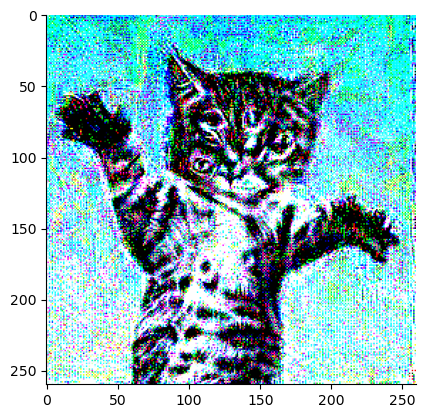

In [9]:
from tqdm import trange, tqdm
from torchvision.transforms import Normalize, Compose, ToTensor

normalizer = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalizer = Normalize([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], [1 / 0.229, 1 / 0.224, 1 / 0.225])

fetcher = featureFetcher_module()
fetcher.record_module(model.layer4, "layer4", ingraph=True)
imgtsr = ToTensor()(img)
# preprocess the image
imgtsr_pp = normalizer(imgtsr)[None, :, :, :]
with torch.no_grad():
    model(imgtsr_pp.cuda())
target_activation = fetcher["layer4"][0].detach()

x = torch.randn_like(imgtsr_pp, requires_grad=True)
optim = torch.optim.Adam([x], lr=0.1)
pbar = trange(1000)
for i in pbar:
    optim.zero_grad()
    model(x.cuda())
    record_activations = fetcher["layer4"]
    loss = torch.nn.functional.mse_loss(record_activations, target_activation)
    loss.backward()
    optim.step()
    pbar.set_postfix(loss=loss.item())
plt.imshow(x[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


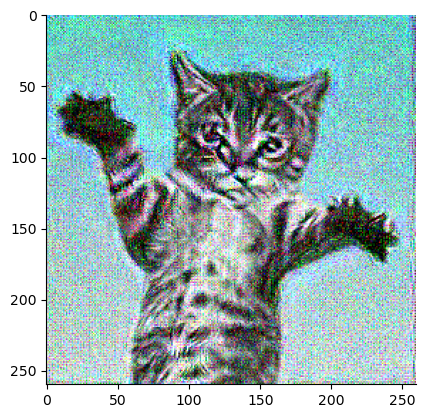

In [51]:
denormalizer = Normalize([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], [1 / 0.229, 1 / 0.224, 1 / 0.225])
plt.imshow(denormalizer(x[0].detach().cpu()).numpy().transpose(1, 2, 0))
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 95.79it/s, loss=3.28e-6]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


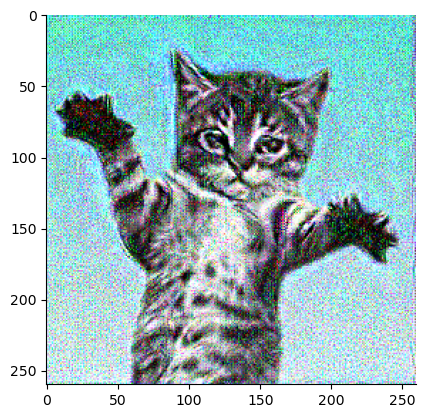

In [18]:
from tqdm import trange, tqdm
from torchvision.transforms import Normalize, Compose, ToTensor

normalizer = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalizer = Normalize([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], [1 / 0.229, 1 / 0.224, 1 / 0.225])
layername = "layer3"
preprocess = Compose([ToTensor(), normalizer])
fetcher = featureFetcher_module()
fetcher.record_module(model.layer3, layername, ingraph=True)
imgtsr = preprocess(img)[None, :, :, :]
# preprocess the image
with torch.no_grad():
    model(imgtsr.cuda())
target_activation = fetcher[layername][0].detach()

x = torch.rand_like(imgtsr, requires_grad=True, device="cuda")
optim = torch.optim.Adam([x], lr=0.02)
pbar = trange(1000)
for i in pbar:
    optim.zero_grad()
    x.data.clamp_(0, 1)
    model(normalizer(x))
    record_activations = fetcher[layername]
    loss = torch.nn.functional.mse_loss(record_activations, target_activation[None])
    loss.backward()
    optim.step()
    pbar.set_postfix(loss=loss.item())
plt.imshow(x[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

### NMF and visualize tensor

In [76]:
import numpy as np
from sklearn.decomposition import NMF
from scipy.optimize import nnls

def compute_explained_variance(W, H, X):
    """
    Compute explained variance for each component.
    
    Parameters:
        W (np.ndarray): Factor matrix with shape (C, n_components)
        H (np.ndarray): Factor matrix with shape (n_components, n_samples)
        X (np.ndarray): Original data matrix with shape (C, n_samples)
    
    Returns:
        explained_variances (np.ndarray): Array of explained variances for each component.
    """
    total_var = np.sum(X ** 2)
    n_components = W.shape[1]
    explained_variances = np.zeros(n_components)
    
    for i in range(n_components):
        # Compute the contribution of the i-th factor as the outer product
        component = np.outer(W[:, i], H[i, :])
        explained_variances[i] = np.sum(component ** 2) / total_var
        
    return explained_variances

def sort_factors(W, H, explained_variances):
    """
    Sort factors in descending order of explained variance.
    
    Parameters:
        W (np.ndarray): Factor matrix with shape (C, n_components)
        H (np.ndarray): Factor matrix with shape (n_components, n_samples)
        explained_variances (np.ndarray): Array of explained variances for each component.
    
    Returns:
        W_sorted, H_sorted, explained_variances_sorted
    """
    sort_idx = np.argsort(explained_variances)[::-1]
    W_sorted = W[:, sort_idx]
    H_sorted = H[sort_idx, :]
    explained_variances_sorted = explained_variances[sort_idx]
    return W_sorted, H_sorted, explained_variances_sorted

def nmf_tensor_nndsvd(tensor, n_components, init='nndsvd'):
    """
    Perform standard NMF on a tensor of shape (C, H, W) using NNDSVD initialization.
    Also compute and sort factors by explained variance.
    
    Parameters:
        tensor (numpy.ndarray): Input tensor with shape (C, H, W).
        n_components (int): Number of components.
    
    Returns:
        W_factor (np.ndarray): Sorted factor matrix (C, n_components).
        H_factor (np.ndarray): Sorted factor matrix (n_components, H*W).
        tensor_reconstructed (np.ndarray): Reconstructed tensor with shape (C, H, W).
        explained_variances (np.ndarray): Explained variances of the sorted components.
    """
    C, H, W = tensor.shape
    X = tensor.reshape(C, -1)
    
    model = NMF(n_components=n_components, init=init, random_state=0, max_iter=500)
    W_factor = model.fit_transform(X)
    H_factor = model.components_
    
    # Compute explained variance for each factor
    exp_var = compute_explained_variance(W_factor, H_factor, X)
    W_sorted, H_sorted, exp_var_sorted = sort_factors(W_factor, H_factor, exp_var)
    
    X_reconstructed = np.dot(W_sorted, H_sorted)
    tensor_reconstructed = X_reconstructed.reshape(C, H, W)
    
    print("Standard NMF with NNDSVD initialization:")
    for i, ev in enumerate(exp_var_sorted):
        print(f"Component {i+1}: Explained Variance = {ev:.4f}")
    
    H_maps = H_sorted.reshape(n_components, H, W)
    return W_sorted, H_sorted, H_maps, tensor_reconstructed, exp_var_sorted

def semi_nmf_tensor(tensor, n_components, n_iter=100):
    """
    Perform semi-NMF on a tensor of shape (C, H, W) by factorizing the reshaped matrix
    into W (unconstrained) and H (nonnegative). Also compute and sort factors by explained variance.
    
    Parameters:
        tensor (numpy.ndarray): Input tensor with shape (C, H, W).
        n_components (int): Number of components.
        n_iter (int): Number of alternating iterations.
    
    Returns:
        W (np.ndarray): Sorted factor matrix (C, n_components) (can be negative).
        H (np.ndarray): Sorted nonnegative factor matrix (n_components, H*W).
        tensor_reconstructed (np.ndarray): Reconstructed tensor with shape (C, H, W).
        explained_variances (np.ndarray): Explained variances of the sorted components.
    """
    C, H_dim, W_dim = tensor.shape
    X = tensor.reshape(C, -1)
    n_samples = X.shape[1]
    
    # Initialize H randomly (nonnegative)
    np.random.seed(0)
    H = np.abs(np.random.randn(n_components, n_samples))
    # Initialize W via unconstrained least squares (solve X = W H)
    W = np.linalg.lstsq(H.T, X.T, rcond=None)[0].T

    for it in range(n_iter):
        # Update H: solve nonnegative least squares for each column of X
        for j in range(n_samples):
            H[:, j], _ = nnls(W, X[:, j])
        # Update W via unconstrained least squares:
        W = np.linalg.lstsq(H.T, X.T, rcond=None)[0].T

    # Compute explained variance for each factor
    exp_var = compute_explained_variance(W, H, X)
    W_sorted, H_sorted, exp_var_sorted = sort_factors(W, H, exp_var)
    
    X_reconstructed = np.dot(W_sorted, H_sorted)
    tensor_reconstructed = X_reconstructed.reshape(C, H_dim, W_dim)
    
    print("\nSemi-NMF (only H nonnegative):")
    for i, ev in enumerate(exp_var_sorted):
        print(f"Component {i+1}: Explained Variance = {ev:.4f}")
    
    return W_sorted, H_sorted, tensor_reconstructed, exp_var_sorted

# Example usage:
if __name__ == "__main__":
    # Create a dummy tensor: 3 channels, height 32, width 32
    C, H_dim, W_dim = 3, 32, 32
    np.random.seed(0)
    tensor = np.random.rand(C, H_dim, W_dim)
    
    n_components = 2
    # Standard NMF with NNDSVD initialization
    W_factor, H_factor, Hmaps, tensor_rec_nmf, exp_var_nmf = nmf_tensor_nndsvd(tensor, n_components)
    print("Reconstructed tensor shape (NMF):", tensor_rec_nmf.shape)
    
    # Semi-NMF: Only H is constrained to be nonnegative
    # W_semi, H_semi, tensor_rec_semi, exp_var_semi = semi_nmf_tensor(tensor, n_components, n_iter=100)
    # print("Reconstructed tensor shape (Semi-NMF):", tensor_rec_semi.shape)

Standard NMF with NNDSVD initialization:
Component 1: Explained Variance = 0.4507
Component 2: Explained Variance = 0.3687
Reconstructed tensor shape (NMF): (3, 32, 32)


In [77]:
W_sorted, H_sorted, Hmaps, tensor_reconstructed, exp_var_sorted = nmf_tensor_nndsvd(target_activation.numpy(), 5, init='nndsvd')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [78]:
from tqdm import trange, tqdm
from torchvision.transforms import Normalize, Compose, ToTensor

def visualize_activation_tensor(target_activation, fetcher, model, layer_name="layer3", img_shape=(1, 3, 256, 256),
                                n_steps=1000, lr=0.1, show_image=True):
    """
    Visualize a target activation by optimizing an input image to match the activation.
    
    Args:
        model: The model to use
        img: The source image to get target activation from
        layer_name: Name of layer to match activations for
        n_steps: Number of optimization steps
        lr: Learning rate for optimization
    """
    normalizer = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    denormalizer = Normalize([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], [1 / 0.229, 1 / 0.224, 1 / 0.225])
    preprocess = Compose([ToTensor(), normalizer])

    # Set up feature fetcher
    fetcher = featureFetcher_module()
    fetcher.record_module(getattr(model, layer_name), layer_name, ingraph=True, store_device="cuda")
    
    # # Get target activation
    # imgtsr = preprocess(img)[None, :, :, :]
    # with torch.no_grad():
    #     model(imgtsr.cuda())
    # target_activation = fetcher[layer_name][0].detach()

    # Optimize input to match activation
    x = torch.rand(img_shape, requires_grad=True, device="cuda")
    optim = torch.optim.Adam([x], lr=lr)
    
    pbar = trange(n_steps)
    for i in pbar:
        optim.zero_grad()
        x.data.clamp_(0, 1)
        model(normalizer(x))
        record_activations = fetcher[layer_name]
        loss = torch.nn.functional.mse_loss(record_activations, target_activation)
        loss.backward()
        optim.step()
        pbar.set_postfix(loss=loss.item())
    
    if show_image:        
        plt.imshow(x[0].detach().cpu().numpy().transpose(1, 2, 0))
        plt.show()
    
    return x[0].detach().cpu().numpy().transpose(1, 2, 0)


In [79]:
imgtsr = preprocess(img)[None, :, :, :]
fetcher.record_module(model.layer4, "layer4", ingraph=False, store_device="cuda")
with torch.no_grad():
    model(imgtsr.cuda())
target_activation = fetcher["layer4"][0].detach()

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_3252604/416900662.py:40: UserWarning: Using a target size (torch.Size([2048, 9, 9])) that is different to the input size (torch.Size([1, 2048, 9, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(record_activations, target_activation)
100%|██████████| 1000/1000 [00:10<00:00, 91.84it/s, loss=0.000893]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


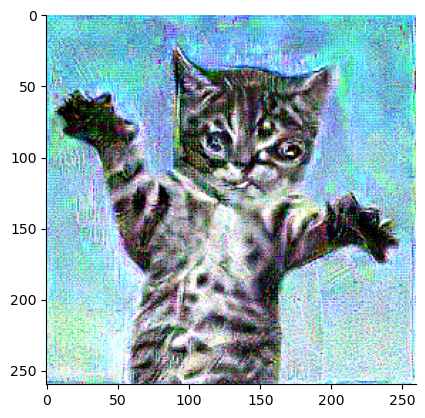

In [80]:
vis_x = visualize_activation_tensor(target_activation.cuda(), fetcher, model, layer_name="layer4", 
                                n_steps=1000, lr=0.02, show_image=True, img_shape=(1, 3, 260, 260))

Standard NMF with NNDSVD initialization:
Component 1: Explained Variance = 0.3820
Component 2: Explained Variance = 0.0871
Component 3: Explained Variance = 0.0840
Component 4: Explained Variance = 0.0750
Component 5: Explained Variance = 0.0460


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_3252604/416900662.py:40: UserWarning: Using a target size (torch.Size([2048, 9, 9])) that is different to the input size (torch.Size([1, 2048, 9, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(record_activations, target_activation)
100%|██████████| 1000/1000 [00:10<00:00, 91.63it/s, loss=0.147]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


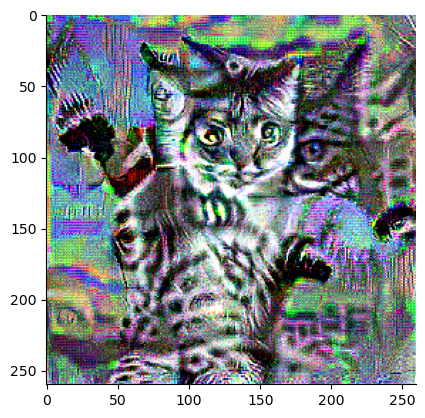

In [89]:
W_sorted, H_sorted, Hmaps, tensor_reconstructed, exp_var_sorted = nmf_tensor_nndsvd(target_activation.cpu().numpy(), 5, init='random')
tensor_nmf = torch.from_numpy(tensor_reconstructed).cuda()
vis_x = visualize_activation_tensor(tensor_nmf, fetcher, model, layer_name="layer4", 
                                n_steps=1000, lr=0.01, show_image=True, img_shape=(1, 3, 260, 260))

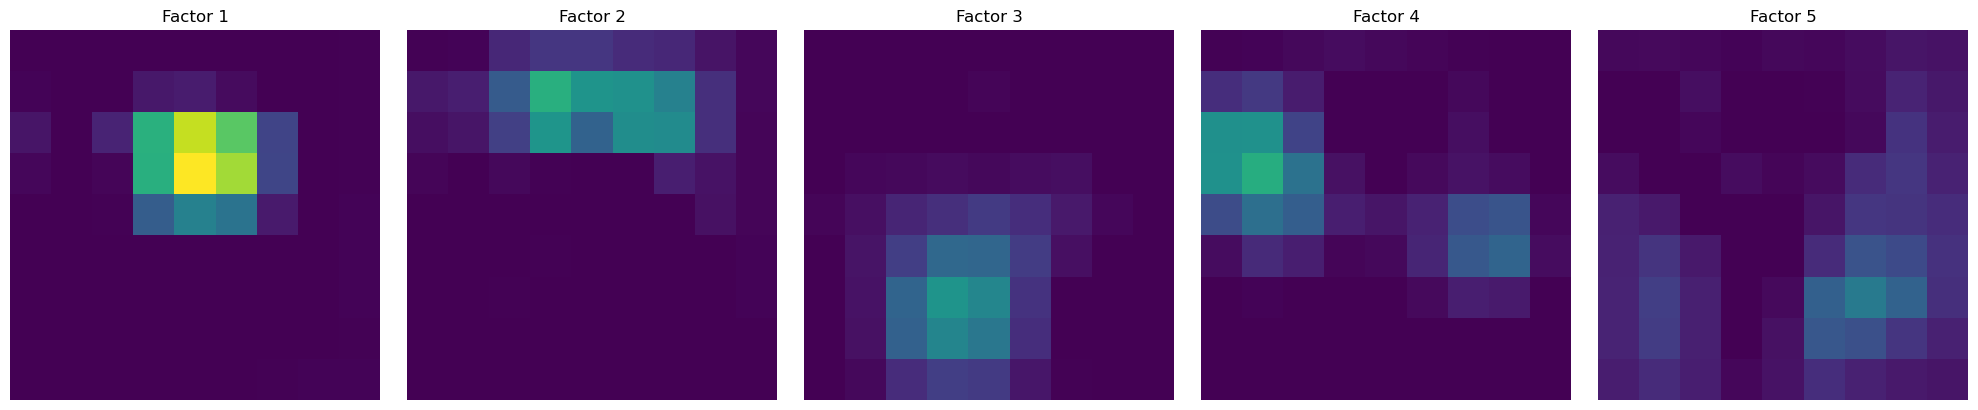

In [74]:
# Create a figure with subplots for each Hmap
n_maps = Hmaps.shape[0]
fig, axs = plt.subplots(1, n_maps, figsize=(4*n_maps, 4))
vmin = Hmaps.min()
vmax = Hmaps.max()
for i in range(n_maps):
    axs[i].imshow(Hmaps[i], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[i].set_title(f'Factor {i+1}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Quadrant shuffling

In [10]:
import torch
import torch.nn.functional as F

def shuffle_quadrants(x):
    """
    Given a 4D tensor x of shape (B, C, H, W), splits it into four quadrants and shuffles them.
    Handles odd H and/or W by temporarily padding the tensor so that H and W are even.
    """
    B, C, H, W = x.shape

    # Determine if padding is necessary (pad at the bottom/right)
    pad_h = 1 if H % 2 != 0 else 0
    pad_w = 1 if W % 2 != 0 else 0

    # Pad the tensor if needed. The pad argument is (pad_left, pad_right, pad_top, pad_bottom)
    if pad_h or pad_w:
        x = F.pad(x, (0, pad_w, 0, pad_h))
    
    # Update dimensions after padding
    _, _, H_pad, W_pad = x.shape
    h_half = H_pad // 2
    w_half = W_pad // 2

    # Split the tensor into four quadrants:
    # top-left, top-right, bottom-left, bottom-right
    q1 = x[:, :, :h_half, :w_half]   # top-left
    q2 = x[:, :, :h_half, w_half:]   # top-right
    q3 = x[:, :, h_half:, :w_half]   # bottom-left
    q4 = x[:, :, h_half:, w_half:]   # bottom-right

    quadrants = [q1, q2, q3, q4]

    # Shuffle the quadrants randomly (using torch.randperm for random permutation)
    perm = torch.randperm(4)
    shuffled_quads = [quadrants[i] for i in perm]

    # Reassemble the shuffled quadrants into a tensor
    top_row = torch.cat([shuffled_quads[0], shuffled_quads[1]], dim=-1)
    bottom_row = torch.cat([shuffled_quads[2], shuffled_quads[3]], dim=-1)
    shuffled_tensor = torch.cat([top_row, bottom_row], dim=-2)

    # Remove any padding that was added, so the output shape matches the input shape (H, W)
    if pad_h or pad_w:
        shuffled_tensor = shuffled_tensor[:, :, :H, :W]

    return shuffled_tensor

# Example usage:
x = torch.arange(1*1*7*7).view(1, 1, 7, 7)
print("Original Tensor Shape:", x.shape)
shuffled = shuffle_quadrants(x)
print("Shuffled Tensor Shape:", shuffled.shape)
print("Shuffled Tensor:\n", shuffled)

Original Tensor Shape: torch.Size([1, 1, 7, 7])
Shuffled Tensor Shape: torch.Size([1, 1, 7, 7])
Shuffled Tensor:
 tensor([[[[28, 29, 30, 31,  0,  1,  2],
          [35, 36, 37, 38,  7,  8,  9],
          [42, 43, 44, 45, 14, 15, 16],
          [ 0,  0,  0,  0, 21, 22, 23],
          [32, 33, 34,  0,  4,  5,  6],
          [39, 40, 41,  0, 11, 12, 13],
          [46, 47, 48,  0, 18, 19, 20]]]])


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 104.19it/s, loss=0.0117]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


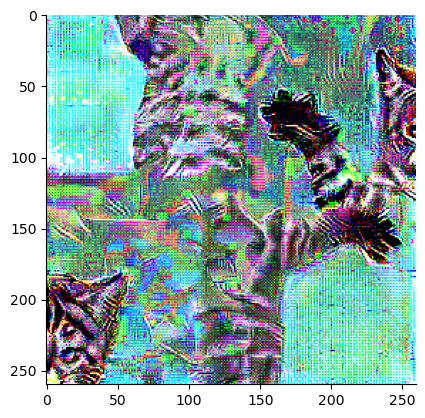

In [11]:
from tqdm import trange, tqdm
from torchvision.transforms import Normalize, Compose, ToTensor

def score_function(x):
    model(x.cuda())
    loss = torch.nn.functional.mse_loss(fetcher["layer3"], target_activation)
    return loss

normalizer = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalizer = Normalize([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], [1 / 0.229, 1 / 0.224, 1 / 0.225])
preprocess = Compose([ToTensor(), normalizer])
fetcher = featureFetcher_module()
fetcher.record_module(model.layer3, "layer3", ingraph=True)
imgtsr = preprocess(img)[None, :, :, :]
# preprocess the image
with torch.no_grad():
    model(imgtsr.cuda())
target_activation = fetcher["layer3"][0].detach()

# manipulate the target activation, spatially
manipulated_target_activation = shuffle_quadrants(target_activation[None])

x = torch.rand_like(imgtsr, requires_grad=True, device="cuda")
optim = torch.optim.Adam([x], lr=0.1)
pbar = trange(1000)
for i in pbar:
    optim.zero_grad()
    x.data.clamp_(0, 1)
    model(normalizer(x))
    record_activations = fetcher["layer3"]
    loss = torch.nn.functional.mse_loss(record_activations, manipulated_target_activation)
    loss.backward()
    optim.step()
    pbar.set_postfix(loss=loss.item())
plt.imshow(x[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

100%|██████████| 1000/1000 [00:09<00:00, 111.05it/s, loss=0.0114]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


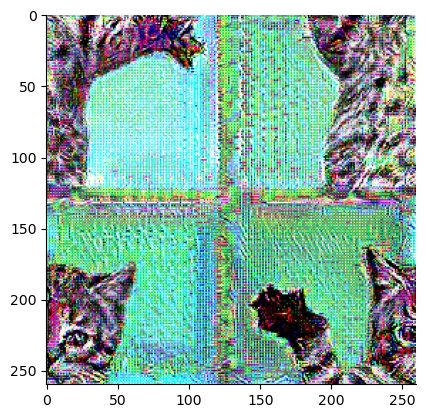

In [13]:
from tqdm import trange, tqdm
from torchvision.transforms import Normalize, Compose, ToTensor

normalizer = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalizer = Normalize([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], [1 / 0.229, 1 / 0.224, 1 / 0.225])
preprocess = Compose([ToTensor(), normalizer])
fetcher = featureFetcher_module()
fetcher.record_module(model.layer2, "layer2", ingraph=True)
imgtsr = preprocess(img)[None, :, :, :]
# preprocess the image
with torch.no_grad():
    model(imgtsr.cuda())
target_activation = fetcher["layer2"][0].detach()

# manipulate the target activation, spatially
manipulated_target_activation = shuffle_quadrants(target_activation[None])

x = torch.rand_like(imgtsr, requires_grad=True, device="cuda")
optim = torch.optim.Adam([x], lr=0.1)
pbar = trange(1000)
for i in pbar:
    optim.zero_grad()
    x.data.clamp_(0, 1)
    model(normalizer(x))
    record_activations = fetcher["layer2"]
    loss = torch.nn.functional.mse_loss(record_activations, manipulated_target_activation)
    loss.backward()
    optim.step()
    pbar.set_postfix(loss=loss.item())
plt.imshow(x[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()